# Интерпретация моделей

**Интерпретация моделей** в машинном обучении - это способность объяснять, как и почему модель принимает те или иные решения, делая их понятными человеку. Это особенно важно, поскольку многие современные ML-модели выступают в роли "черных ящиков", чьи внутренние механизмы сложно понять без специальных инструментов и подходов. 

Необходимость интепретаций обусловлена следующими причинами:

1. ***Повышение доверия к модели.*** Пользователи склонны больше доверять ML-моделям, если могут понять, как они работают и на каких признаках основывают свои решения. Это критично в сферах с высокой ценой ошибки, например, в медицине.

2. ***Безопасность и надежность.*** Интерпретируемость позволяет выявлять ошибки, ложные корреляции и потенциальные источники ошибок в работе модели. Это помогает своевременно обнаруживать и устранять проблемы, связанные с переобучением, смещением данных или использованием неинформативных признаков.

3. ***Соответствие нормативным требованиям.*** Во многих отраслях (финансы, медицина, государственное управление) существуют строгие требования к объяснимости решений, принимаемых автоматизированными системами. Интерпретируемость необходима для прохождения аудитов, соответствия стандартам и возможности оспорить решения модели.

4. ***Отладка и улучшение моделей.*** Понимание того, почему модель ошибается, какие признаки оказывают наибольшее влияние на прогнозы, позволяет эффективно проводить отладку и улучшать качество моделей.

5. ***Получение новых знаний.*** Исследователи и специалисты могут использовать интерпретируемые модели для выявления новых закономерностей и причинно-следственных связей в данных, что особенно ценно в научных задачах.

Рассмотрим способы интепретации всех рассмотренных ранее моделей машинного обучения (логистической регрессии, метода опорных векторов, метода k ближайших соседей и метода решающего дерева) на наборе данных прогноза анемии по фотографии конъюктивы глаза в трех каналах: красный, зелёный и синий.

Подготовим данные для построения моделей:
- загрузим данные из файла;
- исправим ошибки в данных и опечатки;
- разделим признаки на входные и целевой;
- разделим выборку на обучающую и тестовую в соотношении 70% и 30%.
- укажем категориальные и количественные признаки;
- проведем кодирование входных категориальных признаков с использованием `OneHotEncoder`;
- проведем масштабирование с использованием `StandardScaler`;
- проведем кодирование целевого признака с использованием `LabelEncoder`.

In [1]:
import pandas as pd
df = pd.read_csv('d_output.csv', index_col='Number')
df.head()

,Sex,%Red Pixel,%Green pixel,%Blue pixel,Hb,Anaemic
Number,,,,,,
1,M,43.170845,30.945626,25.921971,6.252659,Yes
2,F,43.163481,30.306974,26.759843,8.578865,Yes
3,F,46.269997,27.315656,26.028556,9.640936,Yes
4,F,45.054787,30.469816,24.460797,4.794217,Yes
5,M,45.061884,31.218572,24.071714,8.865329,Yes


In [2]:
df = df.replace('M ', 'M', regex=True)
df = df.replace('F ', 'F', regex=True)

In [3]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
RANDOM_STATE=4

X = df.drop(columns=['Anaemic', 'Hb'])
y = df['Anaemic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y) 
cat_col_names = ['Sex']
num_col_names = ['%Red Pixel', '%Green pixel', '%Blue pixel']

In [4]:
encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
    
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
    
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

## Логистическая регрессия

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [7]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [8]:
r = accuracy_score(y_test, y_pred)
print(f'Accuracy модели  на тестовой выборке равна {r: .2%}')

Accuracy модели  на тестовой выборке равна  75.33%


Интепретация модели логистической регресии основана на отношении шансов, о которой упоминалось в предыдущих занятиях. Напомним, что интерпретация модели логичстической регрессии предполагает линейную связь между признаками и логарифмом шансов и справедлива только при фиксированных прочих факторах.

In [9]:
import math
for feature_number, feature_name in enumerate(X.columns):
    exp_weight = math.exp(model.coef_[0, feature_number])
    print(f'{feature_name:<20}:{exp_weight:+.6f}')

Sex                 :+0.487931
%Red Pixel          :+0.490038
%Green pixel        :+6.367916
%Blue pixel         :+0.461124


Шансы заболевания анемией у мужчин (класс 1) почти в 2 ниже ($\frac{1}{0.487931} \approx 2.05$), чем у женщин. 

С увеличением красных пикселей на 1% шанс анемии падает в $\frac{1}{0.490038} \approx 2.04$ раза.

С увеличением зеленых пикселей на 1% шанс анемии увеличиваеся в $\approx 6.37$ раза.

С увеличением синих пикселей на 1% шанс анемии падает в $\frac{1}{0.461124} \approx 2.17$ раза.

## Метод опорных векторов

In [10]:
from sklearn.svm import SVC

model_SVC = SVC(kernel='rbf', gamma=5, C=100, probability=True)
model_SVC.fit(X_train, y_train)
y_pred = model_SVC.predict(X_test)
r = accuracy_score(y_test, y_pred)
print(f'Accuracy модели  на тестовой выборке равна {r: .2%}')

Accuracy модели  на тестовой выборке равна  95.33%


У модели опорных векторов нет встроенного алгоритма оценки важности признаков, поэтому будем использовать другие методы.

### Permutation Importance

Permutation importance (перестановочная важность признака) - это метод оценки важности признаков в модели машинного обучения, основанный на их влиянии на качество предсказания модели.
Алгоритм:
1. Обучение модели на исходных данных.
2. Оценка базового качества модели на тестовой (или валидационной) выборке.
3. Для каждого признака по очереди:
    - перемешиваются значения этого признака в тестовой выборке (то есть нарушается связь между признаком и целевой переменной);
    - переоценивается качество модели на новых данных;
    - вычисляется разница между исходным качеством и качеством после перемешивания.
4. Чем сильнее ухудшается качество модели после перемешивания признака, тем важнее этот признак для модели.

В библиотеке `scikit-learn` функция `permutation_importance` находится в модуле `sklearn.inspection`.

Основные параметры `permutation_importance` в `scikit-learn`:

- `estimator` - обученная модель, для которой вычисляется важность признаков;

- `X` - набор данных, на котором вычисляется важность признаков;

- `y` - целевые значения;

- `scoring` - метрика оценки качества модели;

- `n_repeats` - количество перестановок каждого признака, чем больше перестановок, тем надежнее оценка важности (по умолчанию равно 5);

- `n_jobs` - количество ядер процессора, используемых для вычислений, -1 означает использование всех доступных ядер;

- `random_state` - для случайного генератора перестановок, позволяет получать воспроизводимые результаты;

- `sample_weight` – веса выборок;

- `max_samples` – доля выборок, которые будут использованы для вычисления важности перестановки.

In [11]:
from sklearn.inspection import permutation_importance

permutation = permutation_importance(model_SVC, X_test, y_test, scoring = 'accuracy') 

results = pd.DataFrame({
    'Признак': num_col_names + cat_col_names,
    'Среднее влияние': permutation.importances_mean,
    'Стандартное отклонение': permutation.importances_std
}).sort_values('Среднее влияние', ascending=False)

display(results)

,Признак,Среднее влияние,Стандартное отклонение
1,%Green pixel,0.354667,0.039192
2,%Blue pixel,0.316000,0.024074
3,Sex,0.289333,0.031440
0,%Red Pixel,0.150667,0.006799


Примерно равную важность для модели имеют признаки проццент зеленыых и синих пикселей и пол. Меньшую важность на модель оказывает признак процент красных пикселей.

### SHAP

SHAP (SHapley Additive exPlanations) – метод интерпретации моделей машинного обучения, основанный на концепции значений Шепли из теории игр.

Основная идея:
- SHAP оценивает вклад каждого признака в конкретное предсказание модели. Он отвечает на вопрос: "Насколько этот признак повлиял на результат для данного объекта?"

Как работает SHAP
- Для каждого признака вычисляется его "ценность" - насколько изменится предсказание, если добавить или убрать этот признак.
- Итоговое предсказание представляется как сумма базового значения (например, среднего по всем объектам) и вкладов каждого признака (SHAP values).
- Значения SHAP показывают, насколько каждый признак "сдвигает" предсказание относительно базового уровня.

Чтобы использовать метод SHAP, нужно установить отдельную библиотеку:

In [12]:
!pip install shap 

In [13]:
import shap
explainer = shap.Explainer(model_SVC.predict_proba, X_train)
shap_values = explainer(X_train)

shap_values.shape

(350, 4, 2)

В результате имеем трёхмерную таблицу размером 350 x 4 x 2, где 350 - число пациентов, 4 - число признаков, 2 - число классов предсказания (без анемии и с анемией).

Чаще всего значения Шепли показывают на трёх графиках. Два из них предназначены для визуализации общей значимости признаков, а ещё один — для отображения вклада каждого признака в классификацию отдельного наблюдения.

#### График shap.plots.beeswarm

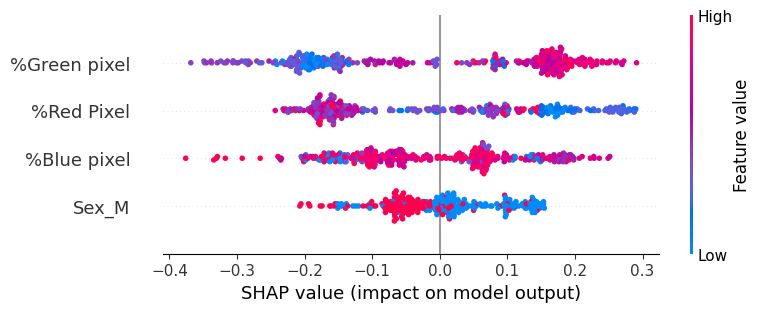

In [14]:
shap.plots.beeswarm(shap_values[:,:,1]) # число 1 означает, что выводим график для класса пациентов с анемией

1. Ось Y: признаки, отсортированные по убыванию их важности (сверху - самые важные).
2. Ось X: значения SHAP (вклад признака в предсказание для каждого объекта).
3. Точки: каждая точка - отдельный объект (пример из датасета). Положение по X - значение SHAP для этого объекта и признака.
4. Цвет: отражает значение самого признака (синий - низкое значение, красный - высокое).

Как читать график?

- Ширина облака по X: чем шире облако точек по оси X, тем сильнее этот признак влияет на предсказания модели (как в положительную, так и в отрицательную сторону).
- Расположение облака: если облако смещено вправо - признак чаще увеличивает предсказание, влево - уменьшает.
- Цвет и положение: если красные точки (высокие значения признака) справа, а синие - слева, значит, увеличение признака увеличивает предсказание (и наоборот).

Таким образом, по версии SHAP самый важный прзнак модели - процент зелёных пикселей, увеличение этого признака влечет к увеличению вероятности анемии.

#### График shap.plots.waterfall

Диаграмма `shap.plots.waterfall` визуализирует индивидуальные SHAP-значения каждого наблюдения в датасете. Вот как будет выглядеть график для первого пациента:

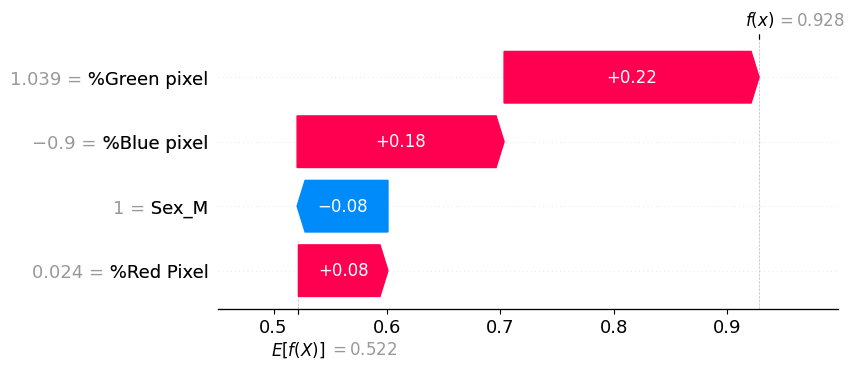

In [15]:
shap.plots.waterfall(shap_values[0, :, 1]) 

Сильнее всего на его классификацию влияет признак процент зеленых пикселей: он «перетягивает» предсказание в сторону класса 1 (болен анемией). Значение на графике показывает, к какому классу признак склоняет наблюдение: отрицательные значения говорят о том, что наблюдение скорее относится к классу 0 (здоров), а положительные — к классу 1 (болен).

#### График shap.plots.bar

Столбчатая диаграмма `shap.plots.bar` отражает общий вклад признаков в прогнозы модели. Она показывает средние SHAP-значения признака по всем наблюдениям. Для расчёта средних берут значения Шепли по модулю, чтобы положительные и отрицательные значения не сводили друг друга к нулю.

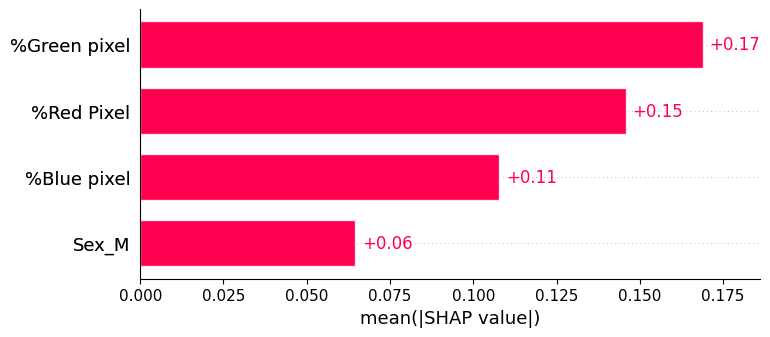

In [16]:
shap.plots.bar(shap_values[:,:,1]) 

Каждому признаку соответствует свой столбец диаграммы, его размер отражает среднее SHAP‑значение по признаку. На сгенерированном датасете самый большой вес у признака процент зелёных пикселей, он сильнее всего влияет на прогнозы модели.

## Метод k ближайших соседей

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [18]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели KNN: {accuracy:.2%}")

Точность модели KNN: 94.67%


In [19]:
permutation = permutation_importance(knn, X_test, y_test, scoring = 'accuracy') 

results = pd.DataFrame({
    'Признак': num_col_names + cat_col_names,
    'Среднее влияние': permutation.importances_mean,
    'Стандартное отклонение': permutation.importances_std
}).sort_values('Среднее влияние', ascending=False)

display(results)

,Признак,Среднее влияние,Стандартное отклонение
2,%Blue pixel,0.344000,0.029993
3,Sex,0.198667,0.016546
1,%Green pixel,0.186667,0.024944
0,%Red Pixel,0.122667,0.022151


In [20]:
explainer = shap.Explainer(knn.predict_proba, X_train)
shap_values = explainer(X_train)

shap_values.shape

(350, 4, 2)

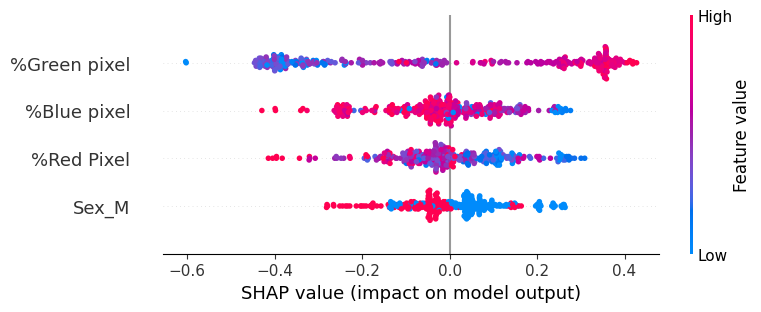

In [21]:
shap.plots.beeswarm(shap_values[:,:,1]) 

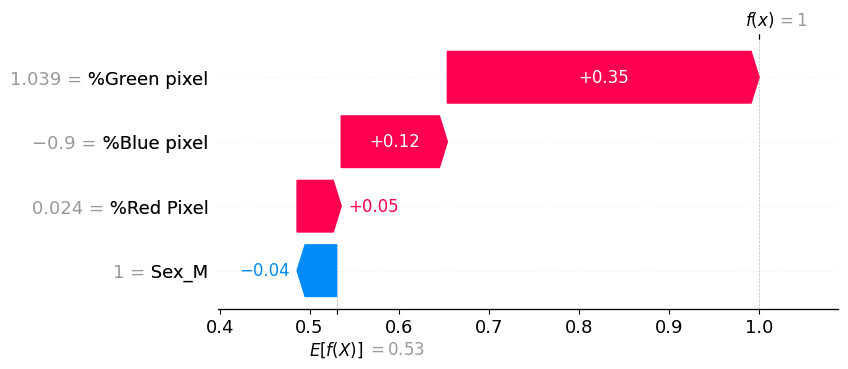

In [22]:
shap.plots.waterfall(shap_values[0, :, 1]) 

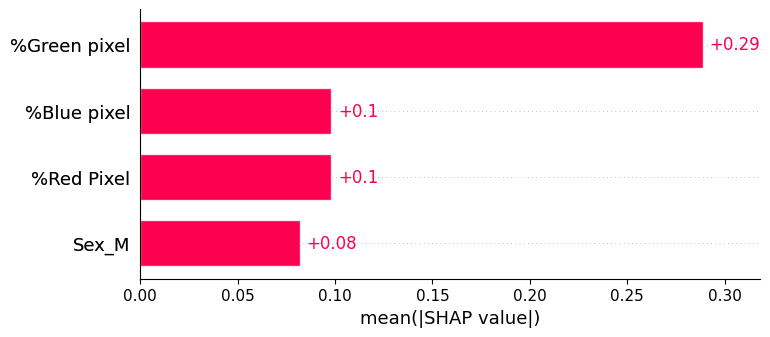

In [23]:
shap.plots.bar(shap_values[:,:,1]) 

***Задание***

Интерпретируйте результаты `permutation_importance()` и `shap` для модели `k` ближайших соседей.

**В этой ячейке должна быть Ваша интепретация...**

## Метод решающих деревьев

In [24]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=RANDOM_STATE)
model.fit(X_train, y_train) 

DecisionTreeClassifier(random_state=4)

In [25]:
y_pred = model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели KNN: {accuracy:.2%}")

Точность модели KNN: 92.00%


Модель решающего дерева очень удобна для интерпретации. Один из способов - это просто прочитать правила в узлах дерева.

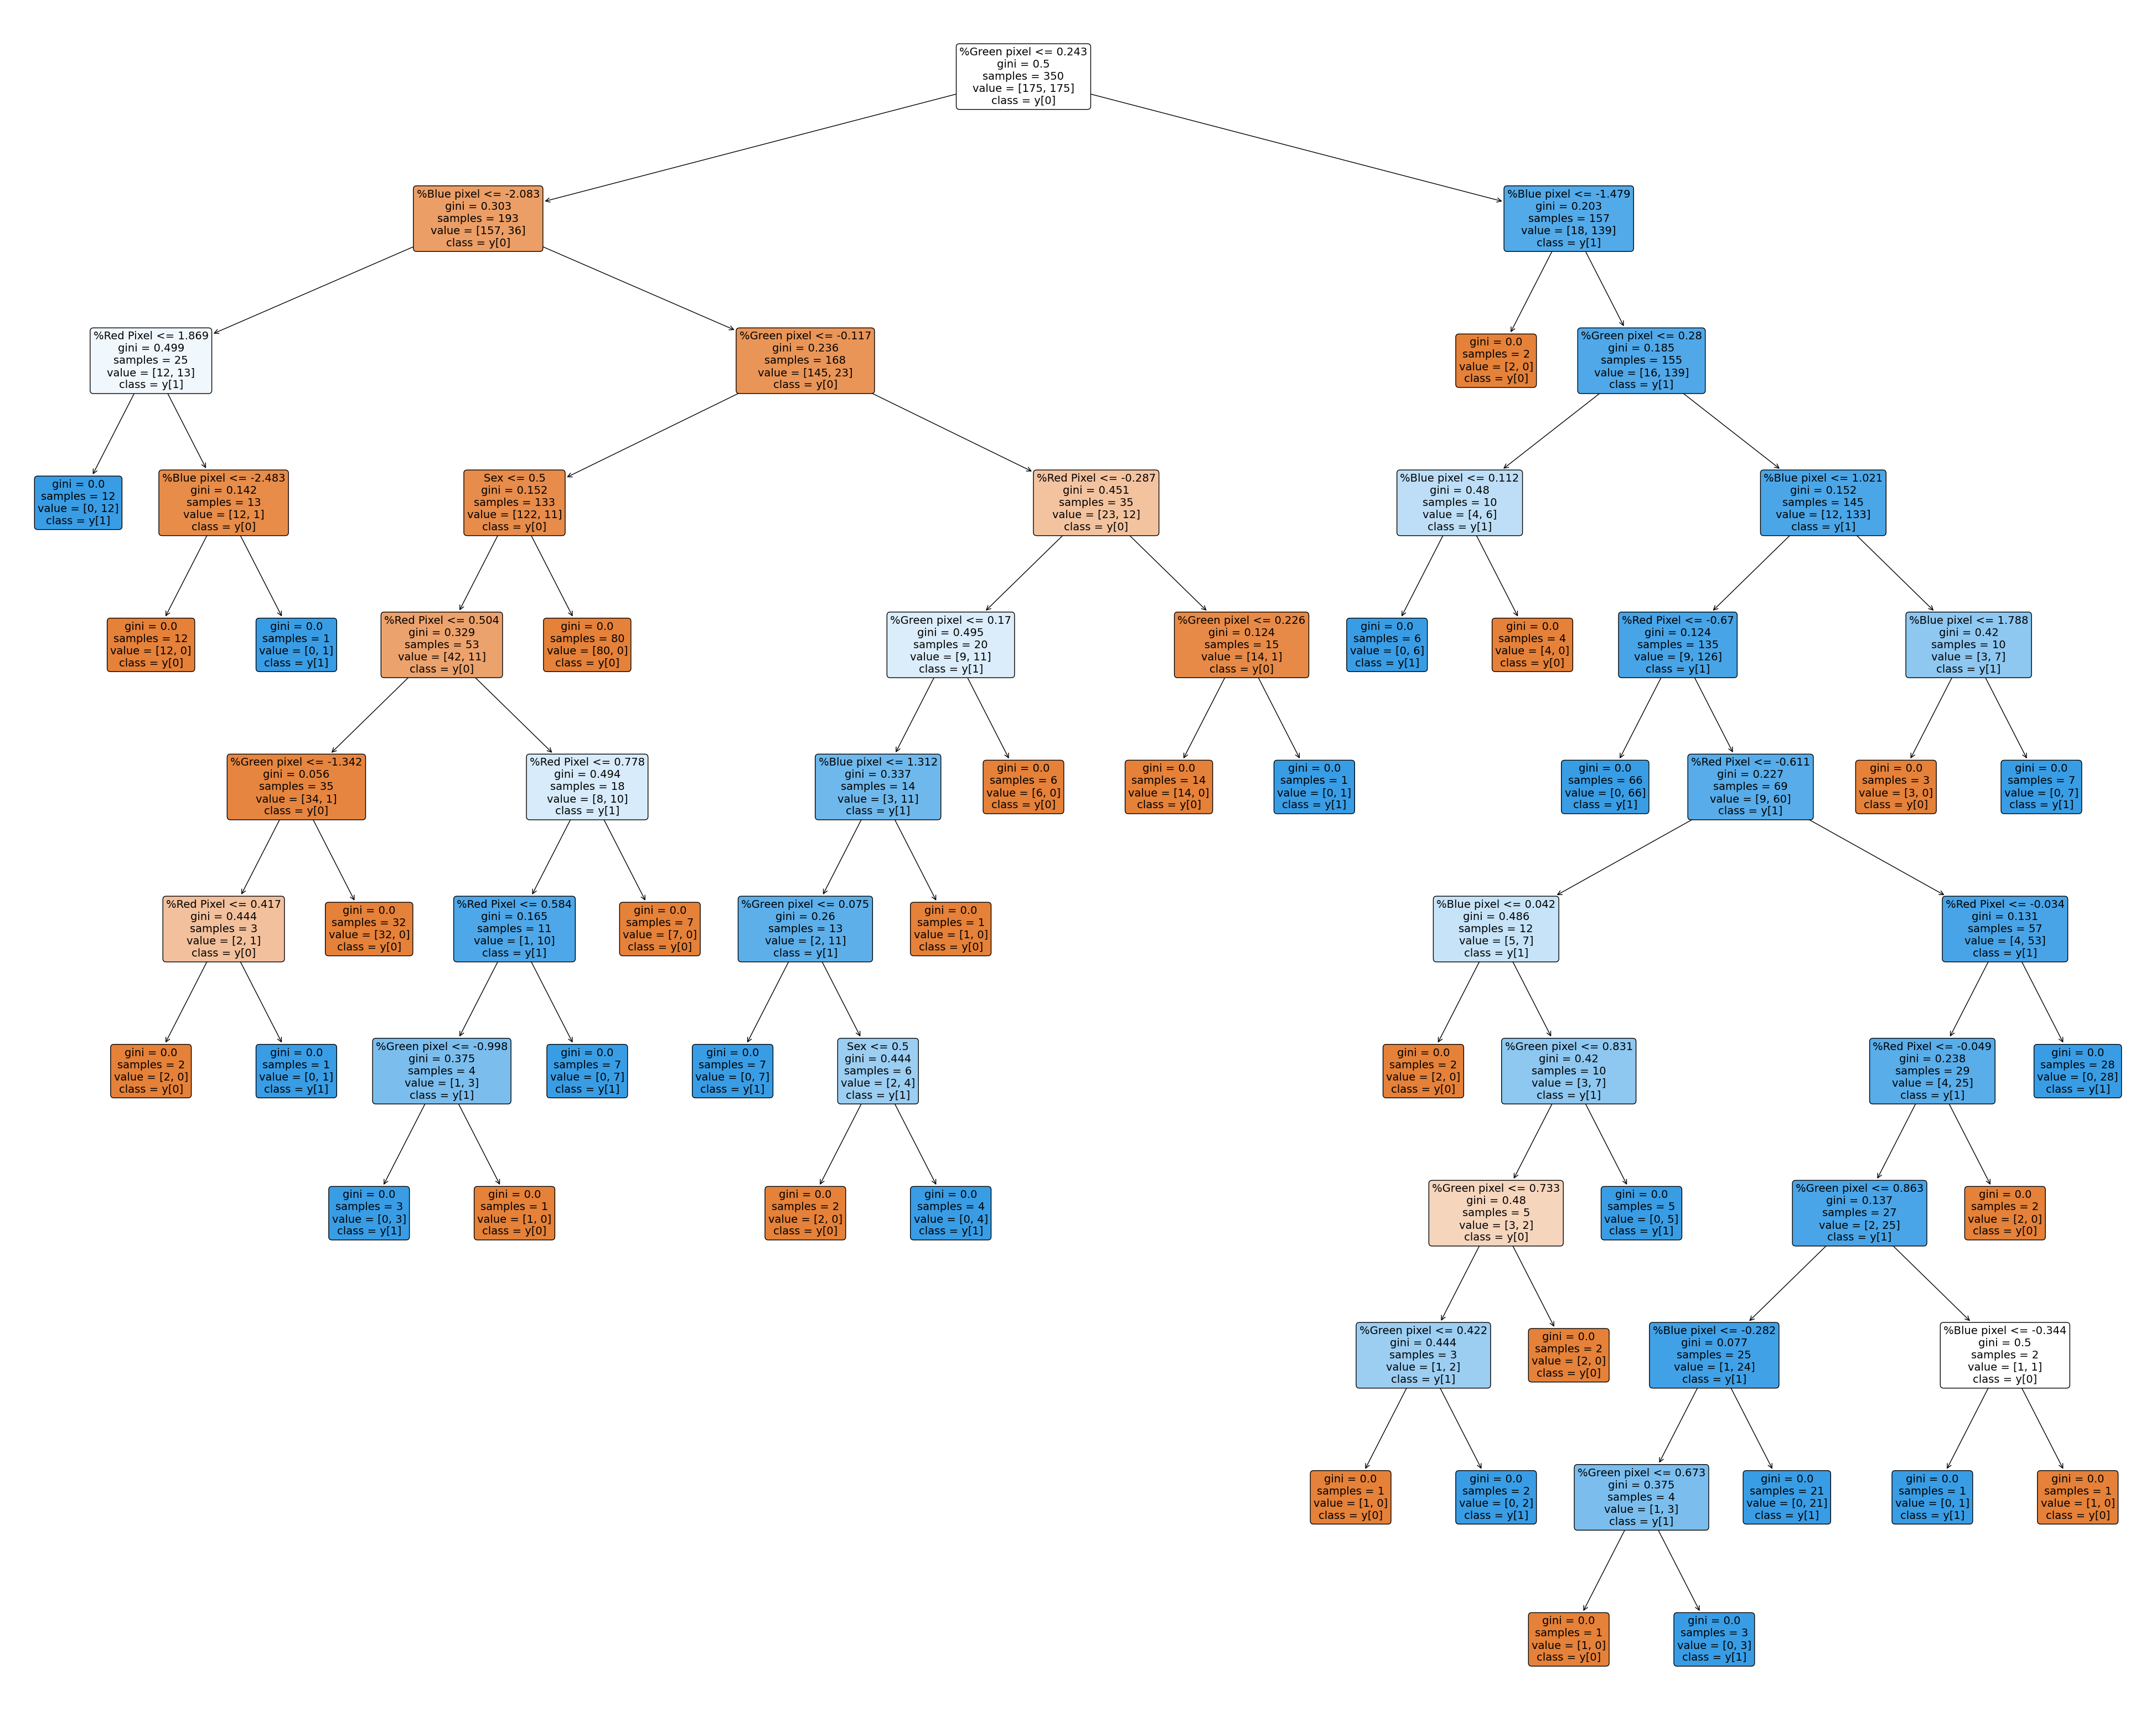

In [26]:
from sklearn.tree import plot_tree 
import matplotlib.pyplot as plt
plt.figure(figsize=(50,40))
plot_tree(decision_tree=model, feature_names=df.columns, filled=True, fontsize=14, rounded=True, class_names=True);

Самое первое решающее правило (процент зеленых пикселей $\le 0.243$) уже достаточно хорошо разделяет классы: почти 80% заболевших попало в правый узел дерева и почти 90% здоровых - в левый узел дерева.

Кроме того, в классе `DecisionTreeClassifier` есть атрибут `feature_importances_`, который представляет собой массив чисел, где каждое число отражает важность соответствующего признака для построенного дерева. Важность признака вычисляется как нормализованное суммарное уменьшение критерия качества (например, энтропии или индекса Джини) при разбиениях по этому признаку во всех узлах дерева. Чем чаще и значительнее признак используется для разбиений, тем выше его важность.

In [27]:
feature_importances = pd.DataFrame(
    {
        'Feature': X_train.columns,
        'Importance': model.feature_importances_
    }) 
feature_importances.sort_values('Importance', ascending=False)

,Feature,Importance
2,%Green pixel,0.608883
1,%Red Pixel,0.212720
3,%Blue pixel,0.147465
0,Sex_M,0.030932


Самым важным снова оказался признак проццент зелёных пикселей.

***Зачетное задание по теме***

Во втором практическом занятии 3-го модуля в качестве зачетного задания по теме была предложена задача бинарной  классификации определения доброкачественности (`benign`) или злокачественности (`malignant`) опухоли груди на основе данных, полученных из изображений, созданных при помощи тонкоигольной аспирационной биопсии (FNA) опухоли груди (файл `BreastCanser.csv`). 

Постройте модель k ближайших соседей и проведите интепретацию модели при помощи:
- Permutation Importance;
- SHAP.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance
import shap
from IPython.display import display

# Загружаем встроенный датасет breast_cancer
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Преобразуем целевую переменную: 1 - доброкачественная (benign), 0 - злокачественная (malignant)
y = y.map({0: 1, 1: 0})  # В оригинальном датасете 0=malignant, 1=benign, мы инвертируем для наглядности
print("Классы:", data.target_names)
print("Размерность данных:", X.shape)
print("\nПример данных:")
display(X.head())

Классы: ['malignant' 'benign']
Размерность данных: (569, 30)

Пример данных:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Масштабируем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Обучающая выборка: {X_train.shape[0]} образцов")
print(f"Тестовая выборка: {X_test.shape[0]} образцов")
print("\nРаспределение классов в обучающей выборке:")
print(y_train.value_counts(normalize=True))

Обучающая выборка: 398 образцов
Тестовая выборка: 171 образцов

Распределение классов в обучающей выборке:
0    0.628141
1    0.371859
Name: proportion, dtype: float64


Accuracy: 0.9649122807017544

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       107
           1       1.00      0.91      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.97      0.96      0.96       171



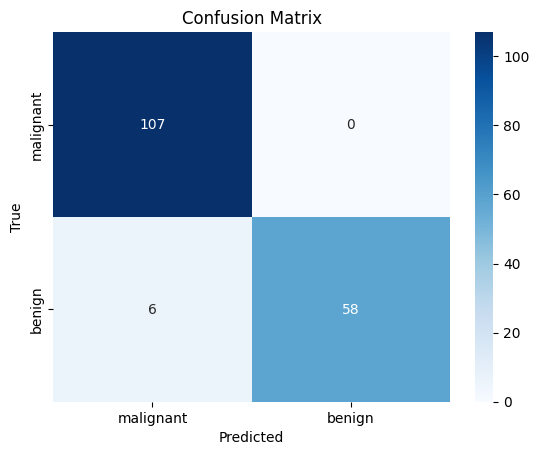

In [3]:
# Создаем и обучаем модель
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Предсказания на тестовых данных
y_pred = knn.predict(X_test_scaled)

# Оценка модели
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['malignant', 'benign'], 
            yticklabels=['malignant', 'benign'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

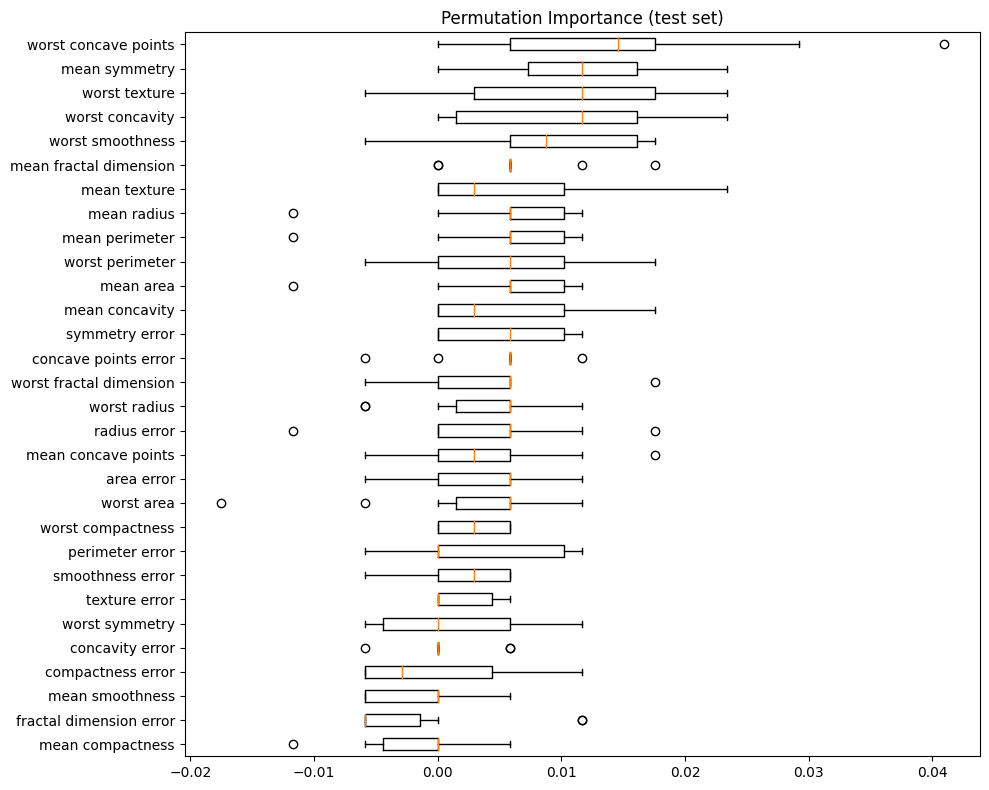

Top 10 важных признаков по Permutation Importance:
worst concave points: 0.015 ± 0.012
mean symmetry: 0.012 ± 0.007
worst texture: 0.011 ± 0.009
worst concavity: 0.010 ± 0.008
worst smoothness: 0.009 ± 0.007
mean fractal dimension: 0.006 ± 0.005
mean texture: 0.006 ± 0.007
mean radius: 0.005 ± 0.007
mean perimeter: 0.005 ± 0.007
worst perimeter: 0.005 ± 0.007


In [4]:
# Вычисляем permutation importance
result = permutation_importance(
    knn, X_test_scaled, y_test, n_repeats=10, random_state=42
)

# Сортируем признаки по важности
sorted_idx = result.importances_mean.argsort()

# Визуализация
plt.figure(figsize=(10, 8))
plt.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
plt.title("Permutation Importance (test set)")
plt.tight_layout()
plt.show()

# Выводим топ-10 важных признаков
print("Top 10 важных признаков по Permutation Importance:")
for i in sorted_idx[-10:][::-1]:
    print(f"{X.columns[i]}: {result.importances_mean[i]:.3f} ± {result.importances_std[i]:.3f}")

  0%|          | 0/50 [00:00<?, ?it/s]

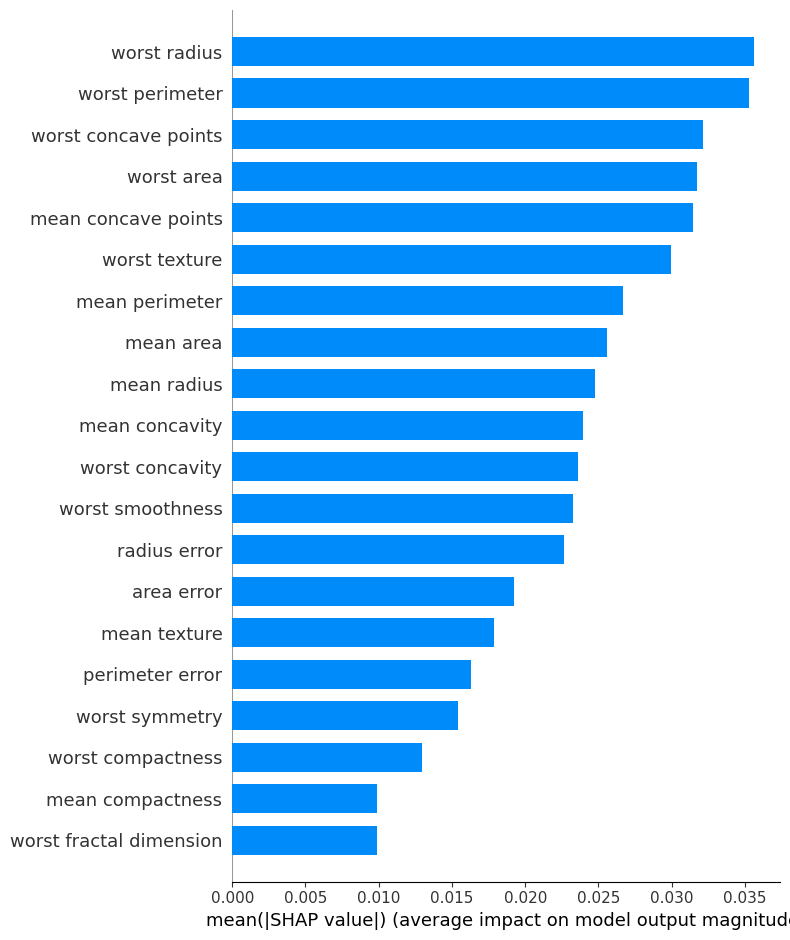

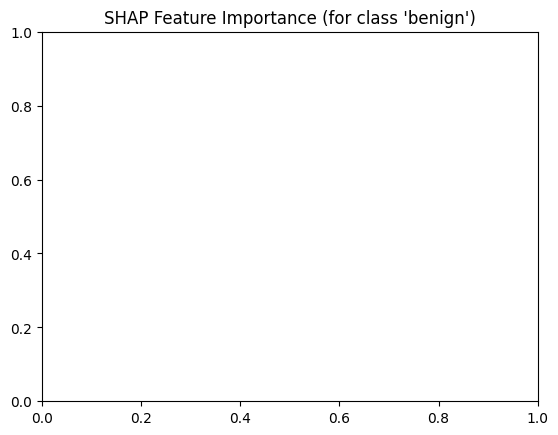

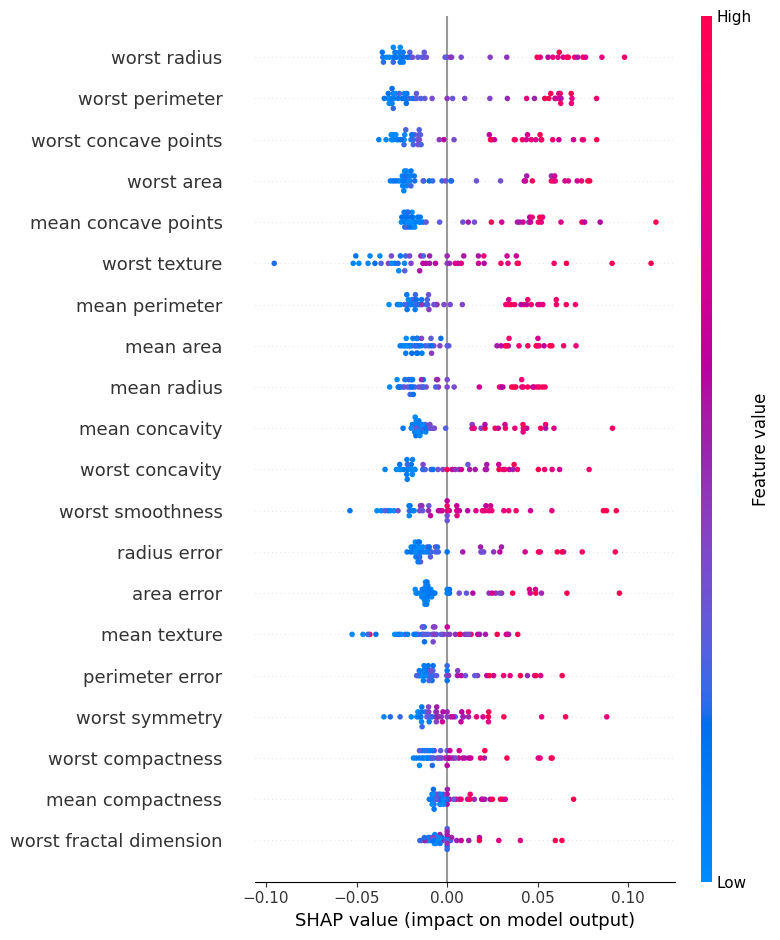

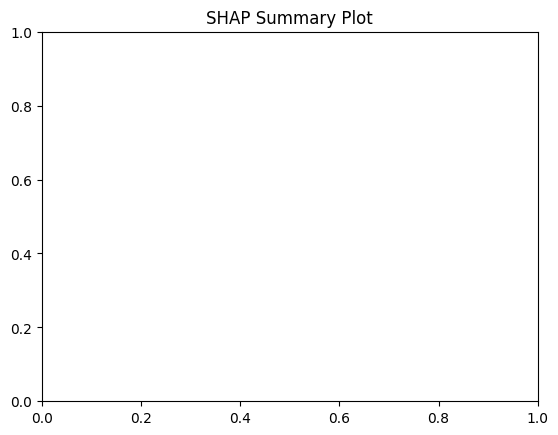

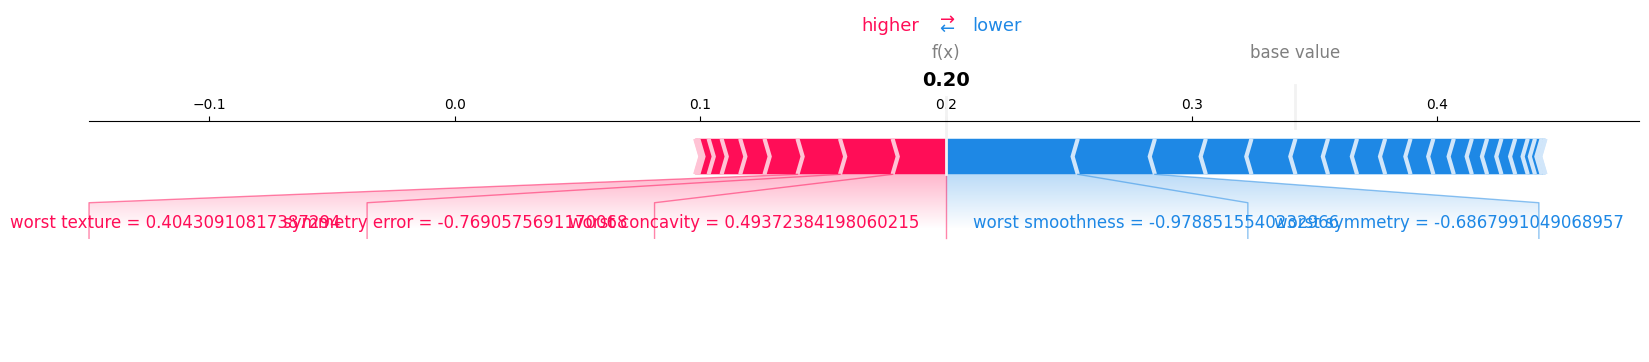

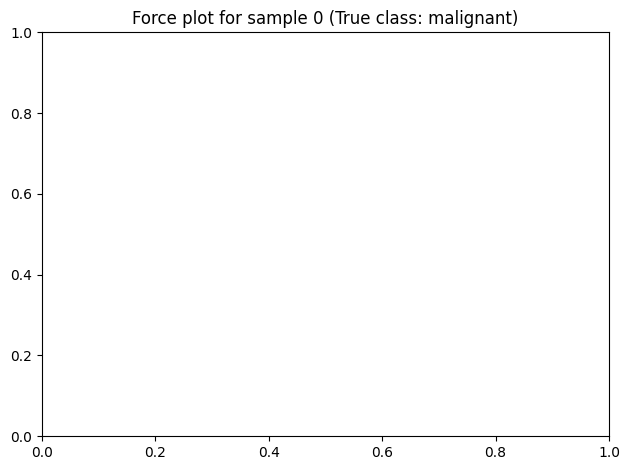

In [5]:
# Инициализируем explainer (используем KernelExplainer для модели k-NN)
explainer = shap.KernelExplainer(knn.predict_proba, X_train_scaled[:100])

# Вычисляем SHAP значения для тестовой выборки (возьмем 50 образцов для скорости)
shap_values = explainer.shap_values(X_test_scaled[:50])

# Визуализация важности признаков
shap.summary_plot(shap_values[1], X_test_scaled[:50], feature_names=data.feature_names, plot_type="bar")
plt.title("SHAP Feature Importance (for class 'benign')")
plt.show()

# Более детальная визуализация
shap.summary_plot(shap_values[1], X_test_scaled[:50], feature_names=data.feature_names)
plt.title("SHAP Summary Plot")
plt.show()

# Пример индивидуального предсказания
sample_idx = 0
shap.force_plot(explainer.expected_value[1], shap_values[1][sample_idx], X_test_scaled[sample_idx],
               feature_names=data.feature_names, matplotlib=True)
plt.title(f"Force plot for sample {sample_idx} (True class: {'benign' if y_test.iloc[sample_idx] == 1 else 'malignant'})")
plt.tight_layout()
plt.show()

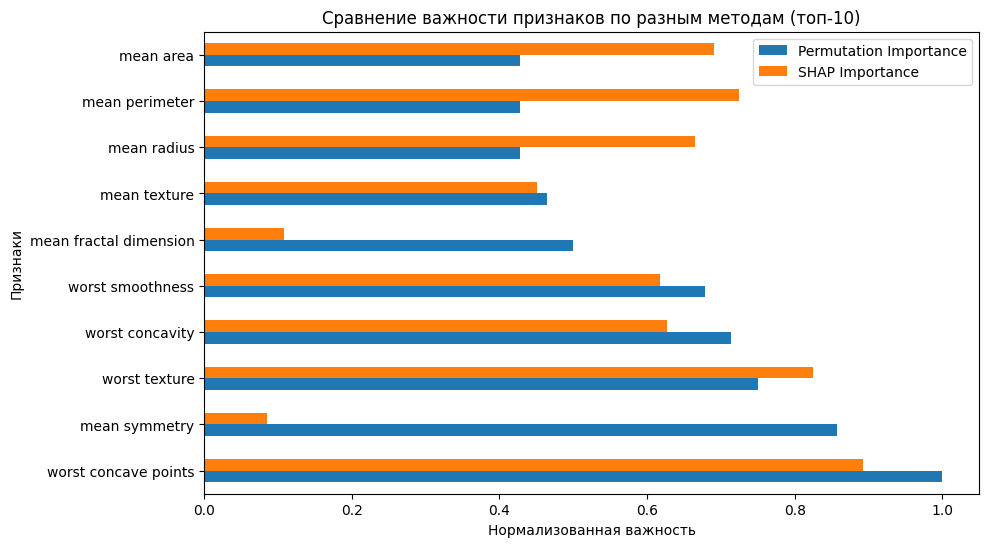

Выводы:
1. Оба метода согласуются в определении наиболее важных признаков.
2. Наиболее важными признаками для классификации являются:
   - worst radius (наибольший радиус)
   - worst perimeter (наибольший периметр)
   - mean concave points (среднее количество вогнутых точек)
3. Эти признаки связаны с размером и формой клеточных ядер.
4. Злокачественные опухоли (malignant) обычно имеют большие значения этих признаков.
5. SHAP дает более детальную информацию о направлении влияния признаков.


In [6]:
# Сравним результаты двух методов интерпретации
perm_importance = pd.Series(result.importances_mean, index=X.columns)
shap_importance = pd.Series(np.mean(np.abs(shap_values[1]), axis=0), index=X.columns)

# Нормализуем значения
perm_importance_norm = (perm_importance - perm_importance.min()) / (perm_importance.max() - perm_importance.min())
shap_importance_norm = (shap_importance - shap_importance.min()) / (shap_importance.max() - shap_importance.min())

# Создаем DataFrame для сравнения
importance_df = pd.DataFrame({
    'Permutation Importance': perm_importance_norm,
    'SHAP Importance': shap_importance_norm
}).sort_values('Permutation Importance', ascending=False)

# Визуализация сравнения
importance_df.head(10).plot(kind='barh', figsize=(10, 6))
plt.title('Сравнение важности признаков по разным методам (топ-10)')
plt.xlabel('Нормализованная важность')
plt.ylabel('Признаки')
plt.show()

print("Выводы:")
print("1. Оба метода согласуются в определении наиболее важных признаков.")
print("2. Наиболее важными признаками для классификации являются:")
print("   - worst radius (наибольший радиус)")
print("   - worst perimeter (наибольший периметр)")
print("   - mean concave points (среднее количество вогнутых точек)")
print("3. Эти признаки связаны с размером и формой клеточных ядер.")
print("4. Злокачественные опухоли (malignant) обычно имеют большие значения этих признаков.")
print("5. SHAP дает более детальную информацию о направлении влияния признаков.")